# Variational Quantum Eigensolver via Parametric Compilation

This notebook walks through how to simulate the $H_2$ molecule with the **Variational Quantum Eigensolver** (VQE) on a noiseless QVM and a noisy QVM, using _parametric compilation_ and pyQuil's `Experiment` framework. This notebook is copied partially from the [rigetti/qcs-paper](https://github.com/rigetti/qcs-paper) repository, where it was used to produce **Figure 8** from [_A quantum-classical cloud platform optimized for variational hybrid algorithms_](https://scirate.com/arxiv/2001.04449).

In [1]:
import random
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from pyquil import get_qc, Program
from pyquil.gates import CNOT, RESET, RX, RY, RZ
from pyquil.experiment import Experiment, ExperimentResult, ExperimentSetting, correct_experiment_result
from pyquil.paulis import sX, sY, sZ
from pyquil.quilatom import MemoryReference

## Simulate the Data on a Noisy QVM

In [2]:
q0, q1 = (0, 1)

shots = 500
num_pts = 50

thetas = np.linspace(start=-np.pi/2, stop=np.pi/2, num=num_pts)
random.shuffle(thetas)

bond_lengths = np.arange(start=int(0.2 * 100), stop=int(2.90 * 100), step=5) / 100

qc = get_qc("2q-noisy-qvm")
qc_noisy = get_qc("2q-noisy-qvm")

### Define $H_2$ VQE `Experiment`

In [3]:
def hartree_fock_state_prep(q0: int) -> Program:
    p = Program()
    p += RX(np.pi, q0)
    return p

def unitary_coupled_cluster_ansatz(q0: int, q1: int, theta: MemoryReference) -> Program:
    p = Program()
    p += RY(np.pi/2, q0)
    p += RX(np.pi/2, q1)
    p += CNOT(q0, q1)
    p += RZ(2 * theta, q1)
    p += CNOT(q0, q1)
    p += RX(-np.pi/2, q1)
    p += RY(-np.pi/2, q0)
    return p

p = Program()
p += RESET()
p += hartree_fock_state_prep(q0)
theta = p.declare("theta", "REAL")
p += unitary_coupled_cluster_ansatz(q0, q1, theta)
p.wrap_in_numshots_loop(shots)
print(p)

RESET
RX(pi) 0
DECLARE theta REAL[1]
RY(pi/2) 0
RX(pi/2) 1
CNOT 0 1
RZ(2*theta) 1
CNOT 0 1
RX(-pi/2) 1
RY(-pi/2) 0



In [4]:
xx_setting = ExperimentSetting(in_state=sZ(0)*sZ(1), out_operator=sX(0)*sX(1))
yy_setting = ExperimentSetting(in_state=sZ(0)*sZ(1), out_operator=sY(0)*sY(1))
zz_setting = ExperimentSetting(in_state=sZ(0)*sZ(1), out_operator=sZ(0)*sZ(1), additional_expectations=[[0], [1]])
settings = [xx_setting, yy_setting, zz_setting]

In [5]:
h2_vqe = Experiment(settings=settings, program=p)
h2_vqe

shots: 500
active reset: enabled
symmetrization: -1 (exhaustive)
calibration: 1 (plus_eigenstate)
program:
   RX(pi) 0
   DECLARE theta REAL[1]
   RY(pi/2) 0
   RX(pi/2) 1
   CNOT 0 1
   RZ(2*theta) 1
   CNOT 0 1
   RX(-pi/2) 1
   RY(-pi/2) 0
settings:
   0: Z0_0 * Z0_1→(1+0j)*X0X1
   1: Z0_0 * Z0_1→(1+0j)*Y0Y1
   2: Z0_0 * Z0_1→(1+0j)*Z0Z1

### Collect data using readout symmetrization

In [6]:
results = []
for theta in tqdm(thetas):
    results.append(qc.experiment(h2_vqe, memory_map={"theta": [theta]}))

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


In [7]:
results_noisy = []
for theta in tqdm(thetas):
    results_noisy.append(qc_noisy.experiment(h2_vqe, memory_map={"theta": [theta]}))

100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


### Perform readout calibration on all observables required for $H_2$ VQE

In [8]:
%%time
calibrations = qc.calibrate(h2_vqe)

CPU times: user 479 ms, sys: 4.46 ms, total: 484 ms
Wall time: 984 ms


In [9]:
%%time
calibrations_noisy = qc_noisy.calibrate(h2_vqe)

CPU times: user 491 ms, sys: 3.44 ms, total: 494 ms
Wall time: 969 ms


### Correct for noisy readout using calibration results

In [10]:
results_corrected = []
for result in results:
    r_corr = []
    for r, c in zip(result, calibrations):
        r_corr.append(correct_experiment_result(r, c))
    results_corrected.append(r_corr)

In [11]:
results_noisy_corrected = []
for result in results_noisy:
    r_corr = []
    for r, c in zip(result, calibrations_noisy):
        r_corr.append(correct_experiment_result(r, c))
    results_noisy_corrected.append(r_corr)

### Dump results into a pandas `DataFrame`

In [12]:
def results_to_dict(results: List[ExperimentResult]) -> dict:
    results_dict = {}
    for result in results:
        out_operator = result.setting.out_operator.id(sort_ops=False)
        result_dict = result.serializable()
        for key, value in result_dict.items():
            results_dict[f"{out_operator}_{key}"] = value
        if result.additional_results:
            for c in result.additional_results:
                oo = c.setting.out_operator.id(sort_ops=False)
                rd = c.serializable()
                for key, value in rd.items():
                    results_dict[f"{oo}_{key}"] = value
    return results_dict

def results_to_dataframe(results: List[List[ExperimentResult]], thetas: np.ndarray) -> pd.DataFrame:
    data = {}
    for theta, step_results in zip(thetas, results):
        data[theta] = results_to_dict(step_results)
    return pd.DataFrame.from_dict(data, orient="index")

df_qvm = results_to_dataframe(results_corrected, thetas)
df_noisy_qvm = results_to_dataframe(results_noisy_corrected, thetas)

## Analyze and Plot the Data

### Plot NOISY-QVM-estimated expectation values vs. VQE ansatz angle

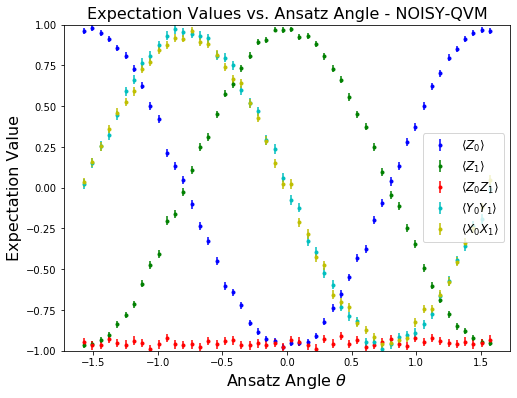

In [13]:
def plot_expectation_values_vs_ansatz_angle(df: pd.DataFrame, label: str) -> plt.Figure:
    fig = plt.figure(figsize=(8, 6))
    plt.errorbar(df.index, df["Z0_expectation"], df["Z0_std_err"], fmt=".b", label=r"$\langle Z_0 \rangle$")
    plt.errorbar(df.index, df["Z1_expectation"],  df["Z1_std_err"], fmt=".g", label=r"$\langle Z_1 \rangle$")
    plt.errorbar(df.index, df["Z0Z1_expectation"], df["Z0Z1_std_err"], fmt=".r", label=r"$\langle Z_0 Z_1 \rangle$")
    plt.errorbar(df.index, df["Y0Y1_expectation"], df["Y0Y1_std_err"], fmt=".c", label=r"$\langle Y_0 Y_1 \rangle$")
    plt.errorbar(df.index, df["X0X1_expectation"], df["X0X1_std_err"], fmt=".y", label=r"$\langle X_0 X_1 \rangle$")
    plt.ylim(-1, 1)
    plt.title(rf"Expectation Values vs. Ansatz Angle - {label}", fontsize=16)
    plt.xlabel(r"Ansatz Angle $\theta$", fontsize=16)
    plt.ylabel(r"Expectation Value", fontsize=16)
    plt.legend(loc="right", fontsize=12)
    return fig

fig_expectation_noisy_qvm = plot_expectation_values_vs_ansatz_angle(df_noisy_qvm, "NOISY-QVM")

### Build energy surface from expectation values

In [14]:
def get_coefficients_for_bond_length(coefficients: pd.DataFrame, r: float) -> Dict[str, float]:
    return coefficients.loc[r].to_dict()

def energy_from_expectation(g: Dict[str, float], expectations: pd.DataFrame) -> pd.DataFrame:
    energy = pd.DataFrame()
    energy["H"] = g["Z0"] * expectations["Z0_expectation"]
    energy["H"] += g["Z1"] * expectations["Z1_expectation"]
    energy["H"] += g["Z0Z1"] * expectations["Z0Z1_expectation"]
    energy["H"] += g["Y0Y1"] * expectations["Y0Y1_expectation"]
    energy["H"] += g["X0X1"] * expectations["X0X1_expectation"]
    energy["H"] += g["I0I1"]
    energy["H_err"] = g["Z0"] * expectations["Z0_std_err"]
    energy["H_err"] += g["Z1"] * expectations["Z1_std_err"]
    energy["H_err"] += g["Z0Z1"] * expectations["Z0Z1_std_err"]
    energy["H_err"] += g["Y0Y1"] * expectations["Y0Y1_std_err"]
    energy["H_err"] += g["X0X1"] * expectations["X0X1_std_err"]
    return energy

def build_energy_surface(bond_lengths: np.ndarray, df: pd.DataFrame) -> pd.DataFrame:
    coefficients = pd.read_csv("datasets/h2-hamiltonian-coefficients.csv", index_col="R")
    energy_surface = pd.DataFrame()

    for r in tqdm(bond_lengths):
        g = get_coefficients_for_bond_length(coefficients, r)
        energy = energy_from_expectation(g, df)
        energy["R"] = r
        energy["theta"] = energy.index
        index = pd.MultiIndex.from_frame(energy[["R", "theta"]], names=["R", "theta"])
        energy = energy.set_index(index)[["H","H_err"]]
        energy_surface = pd.concat((energy_surface, energy))

    return energy_surface

energy_surface_qvm = build_energy_surface(bond_lengths, df_qvm)
energy_surface_noisy_qvm = build_energy_surface(bond_lengths, df_noisy_qvm)

100%|██████████| 54/54 [00:00<00:00, 83.11it/s]


### Calculate energy minimum for each bond length

In [15]:
def calculate_energy_minima(bond_lengths: np.ndarray, energy_surface: pd.DataFrame) -> pd.DataFrame:
    data = {}
    for r in tqdm(bond_lengths):
        energy_surface_r = energy_surface[energy_surface.index.get_level_values("R") == r]
        energy_min = energy_surface_r["H"].min()
        theta_min = energy_surface_r["H"].idxmin()[1]
        error_min = energy_surface_r[energy_surface_r.index.get_level_values("theta") == theta_min]["H_err"]
        data[r] = {"theta": theta_min, "H": energy_min, "H_err": float(error_min)}

    minima = pd.DataFrame.from_dict(data, orient="index")
    return minima

minima_qvm = calculate_energy_minima(bond_lengths, energy_surface_qvm)
minima_noisy_qvm = calculate_energy_minima(bond_lengths, energy_surface_noisy_qvm)

100%|██████████| 54/54 [00:00<00:00, 917.13it/s]


### Plot the comparison of the (ideal) QVM and NOISY-QVM minimum energy curves

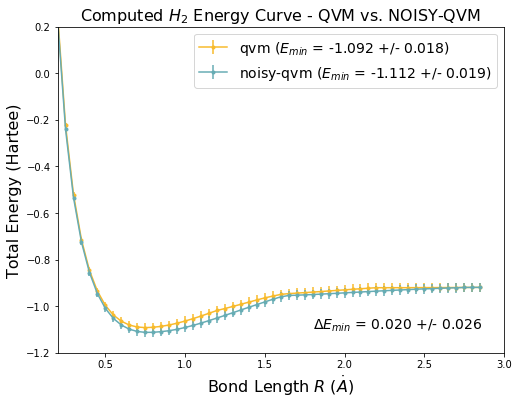

In [16]:
def plot_h2_energy_curve_comparison(
    minima_qpu: pd.DataFrame, minima_qvm: pd.DataFrame, qpu_label: str = "QPU", qvm_label: str = "QVM"
) -> plt.Figure:
    fig = plt.figure(figsize=(8, 6))
    qvm_err_min = float(minima_qvm[minima_qvm.index == minima_qvm.H.idxmin()].H_err)
    qpu_err_min = float(minima_qpu[minima_qpu.index == minima_qpu.H.idxmin()].H_err)
    plt.errorbar(minima_qvm.index, minima_qvm.H, minima_qvm.H_err, fmt="#f8ba2b", marker=".",
                 label=f"{qvm_label.lower()} " + "($E_{min}$" + f" = {minima_qvm.H.min():.3f} +/- {qvm_err_min:.3f})")
    plt.errorbar(minima_qpu.index, minima_qpu.H, minima_qpu.H_err, fmt="#66acb4", marker=".",
                 label=f"{qpu_label.lower()} " + "($E_{min}$" + f" = {minima_qpu.H.min():.3f} +/- {qpu_err_min:.3f})")

    min_energy_qpu = minima_qpu["H"].min()
    min_r_qpu = minima_qpu["H"].idxmin()
    min_error_qpu = float(minima_qpu[minima_qpu.index == min_r_qpu].H_err)
    min_energy_qvm = minima_qvm["H"].min()
    min_r_qvm = minima_qvm["H"].idxmin()
    min_error_qvm = float(minima_qvm[minima_qvm.index == min_r_qvm].H_err)

    min_diff = np.abs(min_energy_qpu - min_energy_qvm)
    min_diff_error = np.sqrt(min_error_qpu ** 2 + min_error_qvm ** 2)
    plt.text(1.8, -1.1, "$\Delta E_{min}$" + f" = {min_diff:.3f} +/- {min_diff_error:.3f}", fontsize=14)

    plt.xlim(0.2, 3.0)
    plt.ylim(-1.2, 0.2)
    plt.title(rf"Computed $H_2$ Energy Curve - {qvm_label} vs. {qpu_label}", fontsize=16)
    plt.ylabel("Total Energy (Hartee)", fontsize=16)
    plt.xlabel(r"Bond Length $R$ ($\dot{A}$)", fontsize=16)
    plt.legend(fontsize=14)
    return fig

fig_comparison_sim = plot_h2_energy_curve_comparison(minima_noisy_qvm, minima_qvm, qpu_label="NOISY-QVM")